In [116]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, Sampler, DataLoader, Subset, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt 
from helper_functions_2 import softmax_kl_loss, sigmoid_rampup, get_current_consistency_weight, linear_rampup, grouper, relabel_dataset
import time


### Load MNSIT

In [117]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '8')

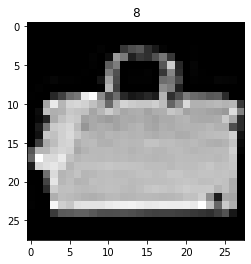

In [118]:
img, label = train_data[99]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(str(label))

### Create custom labelled and unlabelled dataset from MNIST

In [119]:
class Arguments():
    def __init__(self, momentum, weight_decay, nesterov, epochs:int, consistency, exclude_unlabeled:bool, batch_size=64, labeled_batch_size=32, consistency_type='kl', lr=0.01, initial_lr=0.001, lr_rampup = 10, ema_decay=0.999, consistency_rampup=4):
        super().__init__()

        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.nesterov = nesterov
        self.epochs = epochs
        self.consistency_type = consistency_type
        self.initial_lr = initial_lr
        self.lr_rampup = lr_rampup
        self.consistency = consistency
        self.ema_decay = ema_decay
        self.labeled_batch_size = labeled_batch_size
        self.exclude_unlabeled = exclude_unlabeled
        self.batch_size = batch_size
        self.consistency_rampup = consistency_rampup

args = Arguments(lr=0.01, momentum=0, weight_decay=0, nesterov=False, epochs=4, exclude_unlabeled=True, consistency=0, batch_size=32, labeled_batch_size=32)

In [123]:
split = 1-args.labeled_batch_size/args.batch_size
NO_LABEL = -1
BATCH_SIZE = args.batch_size
if(args.exclude_unlabeled == False):
    labelled_train_dataset, unlabelled_train_dataset, labels_train, unlabels_train = train_test_split(train_data.data, train_data.targets, stratify=train_data.targets, test_size=split)
else:
    labelled_train_dataset = train_data.data
    labels_train = train_data.targets

class CustomTrainDataset(Dataset):
    def __init__(self, train_data, labels=None):
        # self.base_data = train_data/255
        self.base_data = train_data
        self.labels = labels
        super().__init__()

    def __len__(self):
        return len(self.base_data)

    def __getitem__(self, idx):
        img = self.base_data[idx]
        if(self.labels is None):
            label = NO_LABEL
            # label = ToTensor(label)
        else:
            label = self.labels[idx]
            label = label.item()
        return img, label
    

In [124]:
labelled_dataset = CustomTrainDataset(train_data=labelled_train_dataset, labels=labels_train)
if(args.exclude_unlabeled == False):
    unlabelled_dataset = CustomTrainDataset(train_data=unlabelled_train_dataset)
    train_dataset = torch.utils.data.ConcatDataset([labelled_dataset, unlabelled_dataset])
else:
    train_dataset = labelled_dataset

# Temporary dataloader serves as checkpoint
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
img = img.cpu().detach().numpy()
# img = img/255
img +=  0.05*np.random.randn(img.shape[0], img.shape[0])
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [125]:
class TwoStreamBatchSampler(Sampler):
     
    def __init__(self, primary_indices, secondary_indices, batch_size, secondary_batch_size):
        self.primary_indices = primary_indices
        self.secondary_indices = secondary_indices
        self.secondary_batch_size = secondary_batch_size
        self.primary_batch_size = batch_size - secondary_batch_size

        assert len(self.primary_indices) >= self.primary_batch_size > 0
        assert len(self.secondary_indices) >= self.secondary_batch_size > 0
        
    def __iter__(self):
            primary_iter = np.random.permutation(self.primary_indices)
            secondary_iter = np.random.permutation(self.secondary_indices)
            return (
                primary_batch + secondary_batch
                for (primary_batch, secondary_batch)
                in  zip(grouper(primary_iter, self.primary_batch_size),
                        grouper(secondary_iter, self.secondary_batch_size)))

    def __len__(self):
        return len(self.primary_indices) // self.primary_batch_size


def create_data_loaders(train_dataset, test_dataset, args):
    
    labeled_idxs, unlabeled_idxs = relabel_dataset(dataset=train_dataset)

    if args.exclude_unlabeled:
        sampler = SubsetRandomSampler(labeled_idxs)
        batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=True)
    else: 
        batch_sampler = TwoStreamBatchSampler(unlabeled_idxs, labeled_idxs, args.batch_size, args.labeled_batch_size)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_sampler=batch_sampler,
                                                pin_memory=True)

    eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False)
    
    return train_loader, eval_loader

train_loader, eval_loader = create_data_loaders(train_dataset, test_data, args)


### Create Model

In [126]:
class FashionMNSITModel_V2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2))
        )


        self.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)
    
def create_models(input_shape: int, hidden_units: int, output_shape:int, ema=False):

    model = FashionMNSITModel_V2(
    input_shape=input_shape,
    hidden_units=hidden_units,
    output_shape=output_shape)

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

In [127]:
model_student = create_models(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_teacher = create_models(input_shape=1, hidden_units=10, output_shape=len(class_names), ema=True)

"""
optimizer = torch.optim.SGD(model_student.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay,
                                nesterov=args.nesterov)
"""

optimizer = torch.optim.SGD(model_student.parameters(), args.lr)



In [128]:
def adjust_learning_rate(optimizer, epoch, batch_num, batches_in_epoch, args):
    lr = args.lr
    epoch = epoch + batch_num / batches_in_epoch

    lr = linear_rampup(epoch, args.lr_rampup) * (args.lr - args.initial_lr) + args.initial_lr

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)

def accuracy_fn(output, target, args, train=False):

    y_preds = torch.argmax(output, dim=1)

    if(train):
        y_preds = y_preds[:args.labeled_batch_size]
        target = target[:args.labeled_batch_size]

    res = sum(torch.eq(y_preds,target)).item() / len(output)
    
    return res



In [129]:
y = torch.tensor([1,0])
y_hat = torch.tensor([[0,1,0],[11,0,2]])

accuracy_fn(y_hat,y, args)


1.0

In [130]:

def train(train_loader, model_student, model_teacher, optimizer, epoch, args):
    global global_step

    # class_criterion = nn.CrossEntropyLoss(reduction="sum",ignore_index=NO_LABEL)
    class_criterion = nn.CrossEntropyLoss()
    if args.consistency_type == 'kl':
        consistency_criterion = softmax_kl_loss

        model_student.train()
        model_teacher.train()

        start = time.time()

        for batch, (X, y) in enumerate(train_loader):

            # Adjust learning rate for minibatach - read more on this and minibatch/batch training
            if(args.exclude_unlabeled == False):
                adjust_learning_rate(optimizer, epoch, batch, len(train_loader), args)

            # Add noise to student and teacher inputs: ideally data should be augmented in the data loader. look more into it
            #student_input_var = X + 0.01*torch.randn(size=X.shape)
            #student_input_var = student_input_var.unsqueeze(dim=1)
            #teacher_input_var = X + 0.01*torch.randn(size=X.shape)
            #teacher_input_var = teacher_input_var.unsqueeze(dim=1)

            student_input_var = X
            teacher_input_var = X

            minibatch_size = len(y)

            # Forward Pass
            student_out = model_student(student_input_var)
            teacher_out = model_teacher(teacher_input_var)
            
            teacher_logit = teacher_out.detach().data

            ## Evaluate the Loss
            classification_loss = class_criterion(student_out, y) / minibatch_size
            teacher_classification_loss = class_criterion(teacher_logit, y) / minibatch_size
            

            if args.consistency:
                consistency_weight = get_current_consistency_weight(epoch, args)
                consistency_loss = consistency_weight * consistency_criterion(student_out, teacher_logit) / minibatch_size
            else:
                consistency_loss = 0

            loss = classification_loss + consistency_loss

            #print("+++++++++++++++++++++++++")
            #print("Loss")
            #print(loss)
            #print("consistency Loss")
            #print(consistency_loss)
            #print("+++++++++++++++++++++++++")
            #print(xxx)
            ## The usual
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1
            
            update_ema_variables(model_student, model_teacher, args.ema_decay, global_step)

            end = time.time()

            num = int(batch/10)
            if batch % 100 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        print(f"Training Loss = {loss}, learning rate = {optimizer.state_dict}")



In [131]:
def validate(eval_loader, model, args):

    test_acc = 0
    class_loss = 0
    class_criterion = nn.CrossEntropyLoss(size_average=False, ignore_index=NO_LABEL)
    model.eval()

    with torch.inference_mode():
        for i, (input, target) in enumerate(eval_loader):

            minibatch_size = len(target)
            output = model(input)
            softmax1 = F.softmax(output, dim=1)
            class_loss += class_criterion(output, target) / minibatch_size

            test_acc += accuracy_fn(output, target, args)
        
        test_acc /= len(eval_loader)
        class_loss /= len(eval_loader)
        
    return test_acc, class_loss
        

In [132]:
from tqdm.auto import tqdm

student_accuracy = []
teacher_accuracy = []

global_step = 0
for epoch in tqdm(range(args.epochs)):
    train(train_loader, model_student, model_teacher, optimizer, epoch, args)
    s_acc, s_loss = validate(eval_loader, model_student, args)
    student_accuracy.append(s_acc)
    t_acc, t_loss = validate(eval_loader, model_teacher, args)
    teacher_accuracy.append(t_acc)
    
    print(f"Student Accuracy = {s_acc*100}, Teacher accuracy = {t_acc*100}")

  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 1, 3, 3], but got 3-dimensional input of size [32, 28, 28] instead

In [63]:
print(student_accuracy)
print(teacher_accuracy)

[0.10041799363057324, 0.10041799363057324, 0.10041799363057324, 0.10041799363057324]
[0.10041799363057324, 0.10041799363057324, 0.10041799363057324, 0.10041799363057324]


In [114]:
X, y = next(iter(eval_loader))
X.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [115]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([32, 28, 28]), torch.Size([32]))